In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
from shortfall.sim import Simulator, SimConfig
from shortfall.miners.repay_proportional import RepayProportionalShortfallMinerState
from shortfall.miners.burn import BurnShortfallMinerState
from shortfall.miners.repay_ratchet import RepayRatchetShortfallMinerState
from shortfall.miners.base import BaseMinerState
from shortfall.network import *
from shortfall.strategy import *
from shortfall.consts import *
import shortfall.gradient.base_cost_models as bcm

import dataclasses
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib as mpl

from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
from tqdm.auto import tqdm
from ipywidgets import *

In [3]:
days = 3 * YEAR + 1
stats_interval = DAY

network = dataclasses.replace(MAINNET_APR_2023,
    token_lease_fee=0.20,
    reward_decay=REWARD_DECAY, # or try REWARD_DECAY + BASELINE_GROWTH
    initial_pledge_projection_period_days=20.0,
    supply_lock_target=0.3
)

In [6]:
def get_base_income(power, total_pledge_needed_for_power, pledge_borrowed, borrow_cost_aer_pct=20):
    base_strategy = StrategyConfig.power_limited(power * TIBIBYTE / EXBIBYTE, 3 * YEAR, False)
    base_miner_factory = BaseMinerState.factory(balance=total_pledge_needed_for_power)
    baseline_cfg = SimConfig(
        network=network,
        strategy=base_strategy,
        miner_factory=base_miner_factory,
    )
    base_stats = Simulator(baseline_cfg).run_all(days, stats_interval)

    # apply cost model(s) on top of this
    borrow_cost_aer = borrow_cost_aer_pct/100.
    income_apy_cost = bcm.compute_income_borrow_apy(
        base_stats, 
        pledge_borrowed, 
        #apy=bcm.APY, 
        apy=borrow_cost_aer, 
        sampling_rate_days=1)
    return np.array(income_apy_cost)

def get_repay_stats(miner_balance, power, max_fee_reward_fraction, shortfall_take_amount):
    max_repayment_term = 3. * 365 * DAY
    repay_miner_factory = RepayRatchetShortfallMinerState.factory(
        balance=miner_balance,
        max_repayment_term=max_repayment_term,
        max_fee_reward_fraction=max_fee_reward_fraction,
        reward_projection_decay=REWARD_DECAY + BASELINE_GROWTH,
        shortfall_take_amount = shortfall_take_amount
    )

    repay_cfg = SimConfig(
        network=network,
        strategy=StrategyConfig.power_limited(power * TIBIBYTE / EXBIBYTE, days, True),
        miner_factory=repay_miner_factory,
    )
    stats_repay = Simulator(repay_cfg).run_all(days, stats_interval)
    return pd.DataFrame(data=stats_repay)

In [7]:
get_repay_stats(0, 100, 0.6, 0.5)

,day,power_eib,balance,lease,pledge_locked,available,net_equity,reward_earned,fee_burned,lease_fee_accrued,pledge_required,shortfall,shortfall_pct
0,1,0.000095,348.03217,348.22287,348.03217,0.0,-0.19070435,0.000000,0.0,0.19070257,696.06433,348.03217,50.0
1,2,0.000095,349.22177,349.12994,349.22177,0.0,0.09182739,1.184255,0.710553,0.3819019,696.06433,346.84256,49.829998
2,3,0.000095,350.41098,350.03732,350.41098,0.0,0.37365723,2.368135,1.420881,0.57359815,696.06433,345.65335,49.66
3,4,0.000095,351.59982,350.94498,351.59982,0.0,0.6548462,3.551640,2.130984,0.7657915,696.06433,344.4645,49.489998
4,5,0.000095,352.7883,351.85287,352.7883,0.0,0.9354248,4.734771,2.840862,0.958482,696.06433,343.27603,49.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,1092,0.000095,712.55615,0.0,696.06433,16.491821,712.55615,1092.726632,169.71484,210.4556,696.06433,0.0,0.0
1092,1093,0.000095,713.3946,0.0,696.06433,17.330261,713.3946,1093.565088,169.71484,210.4556,696.06433,0.0,0.0
1093,1094,0.000095,714.2328,0.0,696.06433,18.168457,714.2328,1094.403278,169.71484,210.4556,696.06433,0.0,0.0
1094,1095,0.000095,715.07074,0.0,696.06433,19.006409,715.07074,1095.241203,169.71484,210.4556,696.06433,0.0,0.0


In [19]:
# since we normalize by power, no need to sweep power!
# feel free to double check this by sweeping it anyway
delta = 50
# tibs_vec = [np.arange(delta, 200+delta, delta)]
tibs_vec = [50]

external_borrow_rate_aer_vec = [15, 20, 25, 30, 35]

delta=0.1
shortfall_taken_pct_vec = np.arange(0.2,0.5+delta,delta)
max_fee_reward_fraction_vec = np.arange(0.2,0.5+delta,delta)
repay_results = {}
base_results = {}
pbar = tqdm(total=len(tibs_vec)*len(shortfall_taken_pct_vec))
for tibs in tibs_vec:
    for shortfall_taken_pct in shortfall_taken_pct_vec:
        max_fee_reward_frac_noop = 0.25  # confirmed this is a NOOP
        shortfall_taken_noop = 0.2
        full_balance_needed = get_repay_stats(0, tibs, max_fee_reward_frac_noop, shortfall_taken_noop).iloc[0]['pledge_required']
        shortfall_amt = shortfall_taken_pct * full_balance_needed
        
        # simulate borrowing same amount from external lender
        for external_borrow_rate_aer in external_borrow_rate_aer_vec:
            key = '%0.02f,%0.02f,%d' % (tibs, shortfall_taken_pct, external_borrow_rate_aer)
            income_base = get_base_income(tibs, full_balance_needed, shortfall_amt, external_borrow_rate_aer)
            base_results[key] = income_base

        for max_fee_reward_fraction in max_fee_reward_fraction_vec:
            key = '%0.02f,%0.02f,%0.02f' % (tibs, max_fee_reward_fraction, shortfall_taken_pct)
            # balance controls the "lease" amount. by setting balance = 0, we are leasing
            # pledge_required * (shortfall_pct)
            miner_balance = 0
            repay_df = get_repay_stats(miner_balance, tibs, max_fee_reward_fraction, shortfall_taken_pct)
            repay_results[key] = repay_df
        pbar.update(1)

  0%|          | 0/4 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


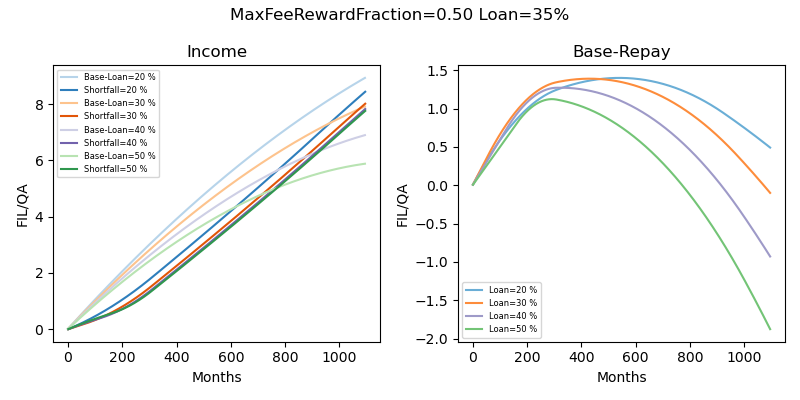

interactive(children=(FloatSlider(value=0.3, description='max_fee_reward_fraction', max=0.5, min=0.2), IntSlid…

<function __main__.update(max_fee_reward_fraction=0.3, external_borrow_rate_aer=20)>

In [22]:
colors = [mpl.colormaps['Blues'], mpl.colormaps['Oranges'], mpl.colormaps['Purples'], mpl.colormaps['Greens']]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
tibs = tibs_vec[0]
def update(max_fee_reward_fraction=0.3, external_borrow_rate_aer=20):
    ax[0].cla()
    ax[1].cla()
    for ii,shortfall_taken_pct in enumerate(shortfall_taken_pct_vec):
        base_key = '%0.02f,%0.02f,%d' % (tibs, shortfall_taken_pct, external_borrow_rate_aer)
        base = base_results[base_key]

        repay_key = '%0.02f,%0.02f,%0.02f' % (tibs, max_fee_reward_fraction, shortfall_taken_pct)
        repay_df = repay_results[repay_key]
        
        base_income = base  # rewards - costs
        repay_income = repay_df.iloc[1:]['net_equity']
        
        ax[0].plot(base/tibs, color=colors[ii](0.3), label='Base-Loan=%d %%' % (shortfall_taken_pct*100,))
        ax[0].plot(repay_income/tibs, color=colors[ii](0.7), label='Shortfall=%d %%' % (shortfall_taken_pct*100,))
        ax[1].plot((base_income-repay_income)/tibs, color=colors[ii](0.5), label='Loan=%d %%' % (shortfall_taken_pct*100,))
        
    ax[0].legend(fontsize=6)
    ax[0].set_ylabel('FIL/QA')
    ax[0].set_xlabel('Months')
    ax[0].set_title('Income')
    ax[1].legend(fontsize=6)
    ax[1].set_title('Base-Repay')
    ax[1].set_ylabel('FIL/QA')
    ax[1].set_xlabel('Months')

    plt.suptitle('MaxFeeRewardFraction=%0.02f Loan=%d%%' % (max_fee_reward_fraction,external_borrow_rate_aer))
    plt.tight_layout()
    fig.canvas.draw_idle()

update()
interact(update, max_fee_reward_fraction=(0.2,0.5,0.1), external_borrow_rate_aer=(15,35,5))

In [ ]:
"""
Plot on the right is showing the relative gains of external-lending to shortfall. If you take
more shortfall, you are better off using external-lending.  This is a property we want.
"""